# Cardiovascular Disease Prediction

## Import Libraries

In [28]:
import os
import pickle

# Data manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import pointbiserialr

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC


## Data Loading

In [5]:
df = pd.read_csv('datasets\cardio_train.csv', sep=';')
print(df.head())

   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


### Features:
    Age | Objective Feature | age | int (days)
    Height | Objective Feature | height | int (cm) |
    Weight | Objective Feature | weight | float (kg) |
    Gender | Objective Feature | gender | categorical code |
    Systolic blood pressure | Examination Feature | ap_hi | int |
    Diastolic blood pressure | Examination Feature | ap_lo | int |
    Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
    Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
    Smoking | Subjective Feature | smoke | binary |
    Alcohol intake | Subjective Feature | alco | binary |
    Physical activity | Subjective Feature | active | binary |
    Presence or absence of cardiovascular disease | Target Variable | cardio | binary |


## Data Cleaning and Preprocessing (missing values, duplicates, outliers, anomalies)


In [6]:
#Cramers Function

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.

        uses correction from Bergsma and Wicher,

        Journal of the Korean Statistical Society 42 (2013): 323-328

    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))  
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [7]:
df['age'] = round(df['age']/365.25)
df['age'] = df['age'].astype(int)

In [9]:
# Dropping ID columns as it is not important for our ML pipeline
df = df.drop(columns='id', axis=1)

In [10]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,48,1,156,56.0,100,60,1,1,0,0,0,0


In [11]:
# Check missing values
df.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [12]:
print(df.describe().T)

               count        mean         std    min    25%    50%    75%  \
age          70000.0   53.303157    6.760171   30.0   48.0   54.0   58.0   
gender       70000.0    1.349571    0.476838    1.0    1.0    1.0    2.0   
height       70000.0  164.359229    8.210126   55.0  159.0  165.0  170.0   
weight       70000.0   74.205690   14.395757   10.0   65.0   72.0   82.0   
ap_hi        70000.0  128.817286  154.011419 -150.0  120.0  120.0  140.0   
ap_lo        70000.0   96.630414  188.472530  -70.0   80.0   80.0   90.0   
cholesterol  70000.0    1.366871    0.680250    1.0    1.0    1.0    2.0   
gluc         70000.0    1.226457    0.572270    1.0    1.0    1.0    1.0   
smoke        70000.0    0.088129    0.283484    0.0    0.0    0.0    0.0   
alco         70000.0    0.053771    0.225568    0.0    0.0    0.0    0.0   
active       70000.0    0.803729    0.397179    0.0    1.0    1.0    1.0   
cardio       70000.0    0.499700    0.500003    0.0    0.0    0.0    1.0   

           

In [13]:
# checking for anomalies cholesterol(1-3),  glucose(1-3), alco(0-1), active(0-1), cardio(0-1)
df.nunique()

age             28
gender           2
height         109
weight         287
ap_hi          153
ap_lo          157
cholesterol      3
gluc             3
smoke            2
alco             2
active           2
cardio           2
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int32  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int32(1), int64(10)
memory usage: 6.1 MB


In [9]:
df.shape

(70000, 13)

In [10]:
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [15]:
# Grouping the columns in our datasets by categorical or continuous cols 
columns = df.columns
categorical_columns = []
continuous_columns = []
for col in columns:
    if col != 'cardio':
        if df[col].nunique() <= 10:
            categorical_columns.append(col)
        else:
            continuous_columns.append(col)

print("Categorical Columns: ", categorical_columns)
print("Continuous Columns: ", continuous_columns)
print(type(continuous_columns))


Categorical Columns:  ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
Continuous Columns:  ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
<class 'list'>


<AxesSubplot: >

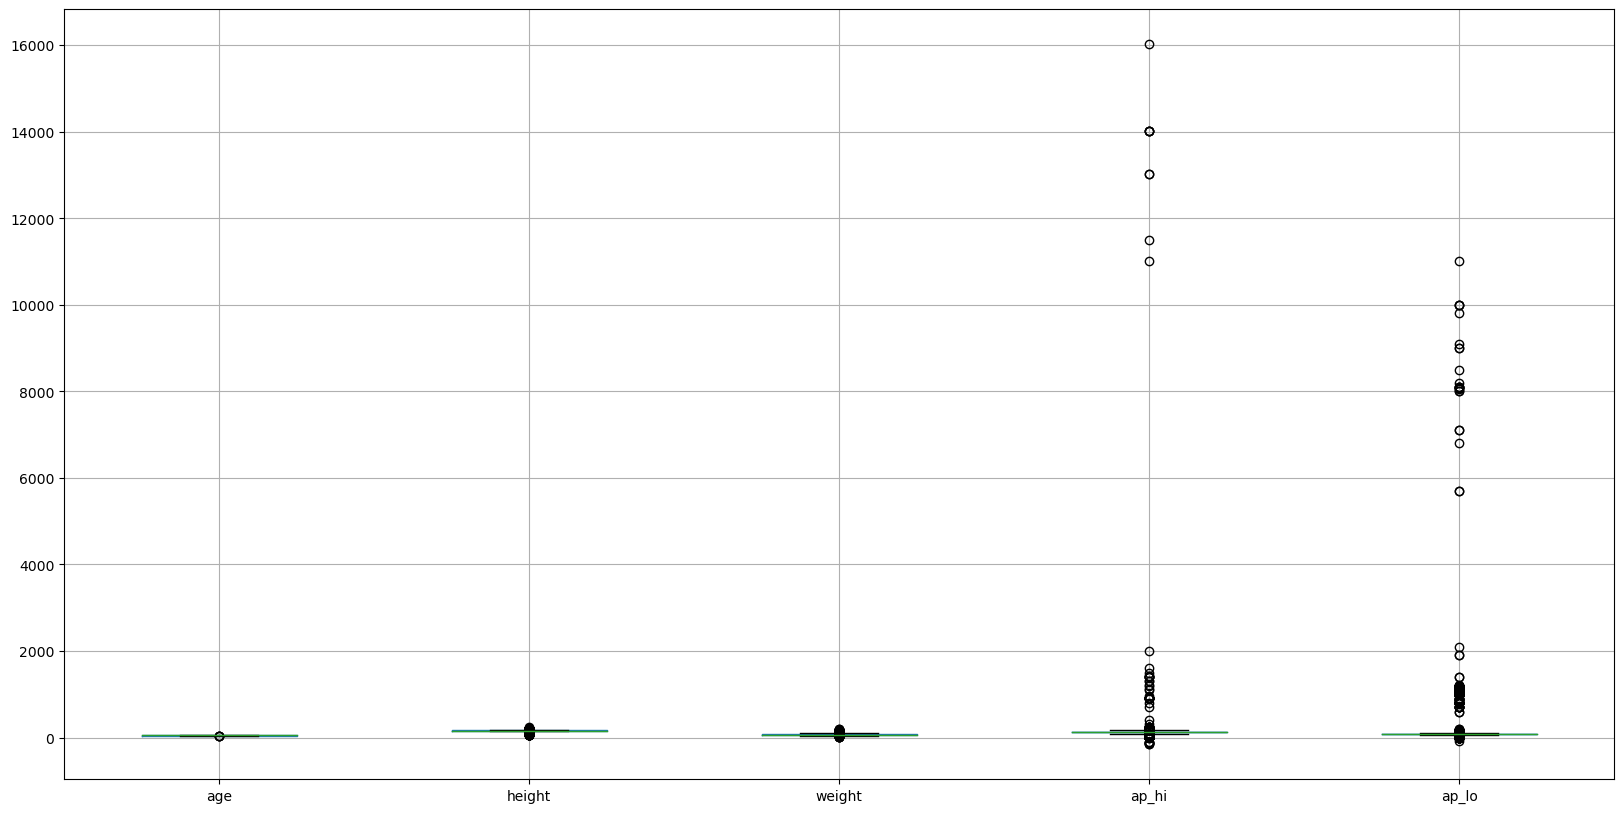

In [16]:
plt.figure(figsize=(20,10))
df.boxplot(continuous_columns)

In [17]:
for x in continuous_columns:
    q75, q25 = np.percentile(df.loc[:,x], [75,25])
    intr_qr = q75 - q25

    maximum = q75+(1.5*intr_qr)
    minimum = q25-(1.5*intr_qr)

    df.loc[df[x] < minimum, x] = np.nan
    df.loc[df[x] > maximum, x] = np.nan

In [18]:
df.isnull().sum()

age               4
gender            0
height          519
weight         1819
ap_hi          1435
ap_lo          4632
cholesterol       0
gluc              0
smoke             0
alco              0
active            0
cardio            0
dtype: int64

In [19]:
df = df.dropna(axis=0)

AxesSubplot(0.125,0.11;0.775x0.77)


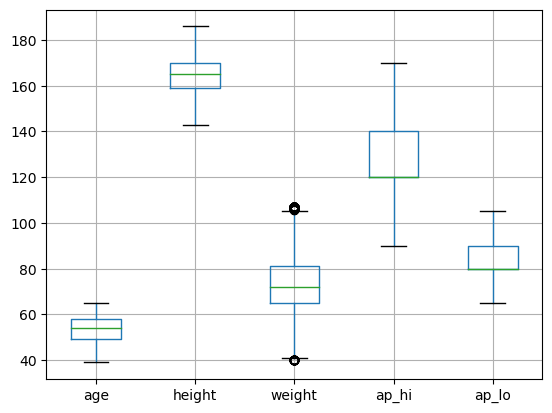

In [20]:
print(df.boxplot(continuous_columns))

## Feature Selection

In [21]:
for i in categorical_columns:
    print(i)
    matrix = pd.crosstab(df[i], df['cardio']).to_numpy()
    print((cramers_corrected_stat(matrix)))

gender
0.0026186567088652257
cholesterol
0.21815752776887948
gluc
0.08712240116268437
smoke
0.02174989281203843
alco
0.011578021297160505
active
0.03742091553026214


In [22]:
for i in continuous_columns:
    print(i)
    lr = LogisticRegression()
    lr.fit(np.expand_dims(df[i], axis=1), df['cardio'])
    print(lr.score(np.expand_dims(df[i], axis=1), df['cardio']))

age
0.5950209593293014
height
0.514063549966401
weight
0.5673578445489744
ap_hi
0.7078333493328214
ap_lo
0.6525711177242328


Point-biserial correlation coefficient for age and cardio: 0.2361515701103966
Point-biserial correlation coefficient for height and cardio: -0.027594818328284556
Point-biserial correlation coefficient for weight and cardio: 0.1617210076437957
Point-biserial correlation coefficient for ap_hi and cardio: 0.43221526847116154
Point-biserial correlation coefficient for ap_lo and cardio: 0.33627833029001425


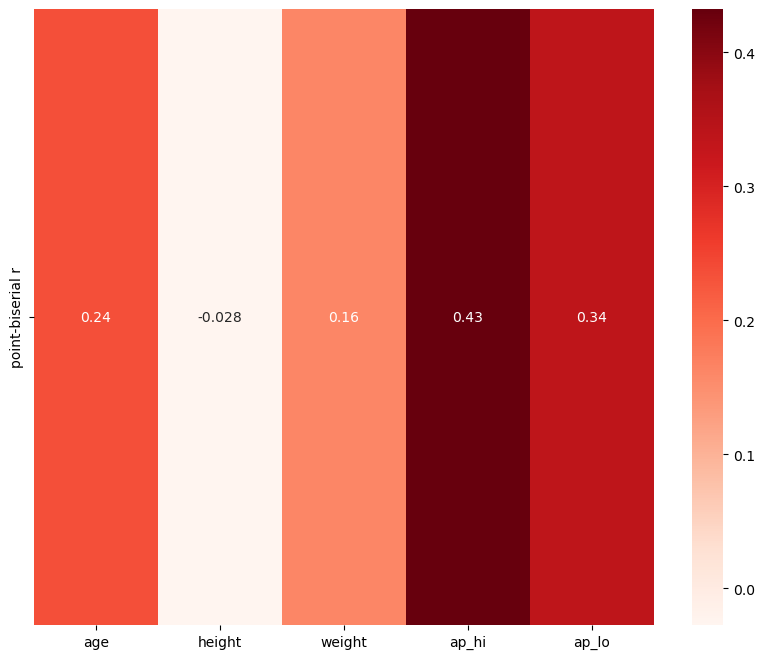

In [26]:
# Point-biserial correlation 
results = {}
for col in continuous_columns:
    if col != 'cardio':
        r, p = pointbiserialr(df[col], df['cardio'])
        results[col] = r
        print(f'Point-biserial correlation coefficient for {col} and cardio: {r}')

# visualize the point-biserial correlation using a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(results, index=['point-biserial r']), cmap='Reds', annot=True)
plt.show()

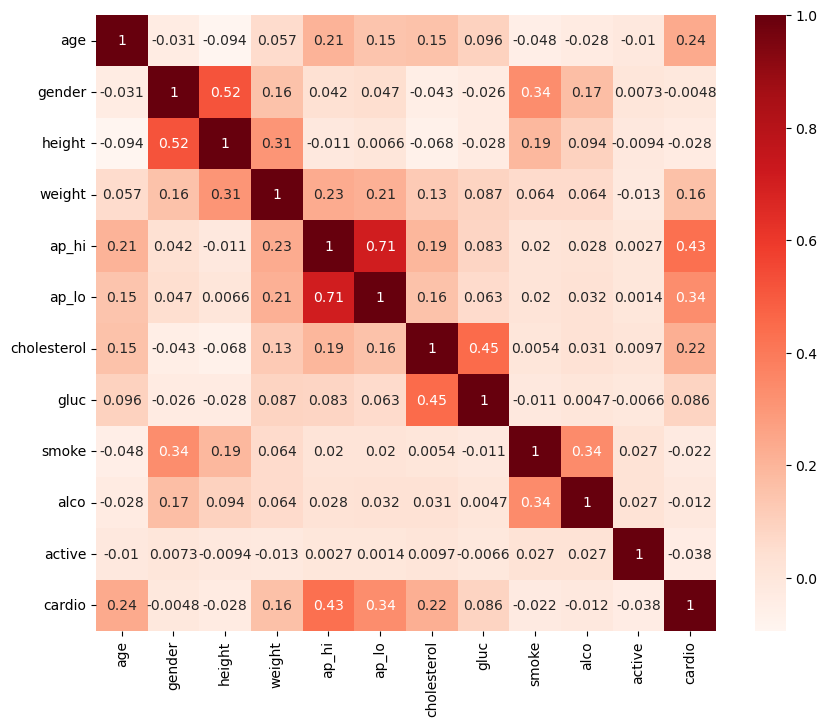

In [27]:
# Relationship between all variables in the dataset
df_all = df
corr_matrix = df_all.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='Reds', annot=True)
plt.show()

## EDA

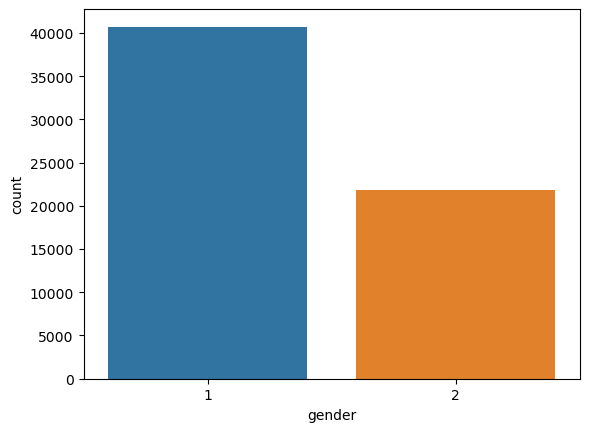

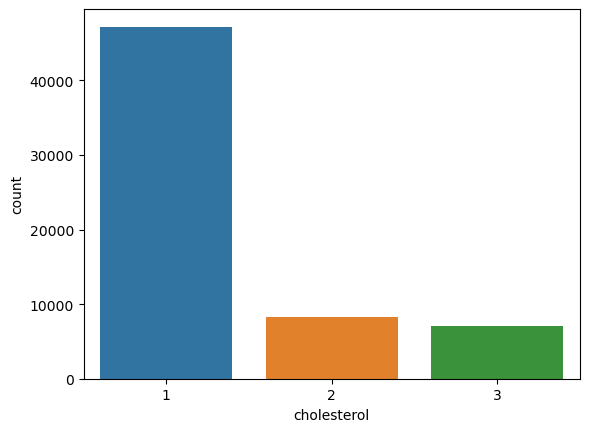

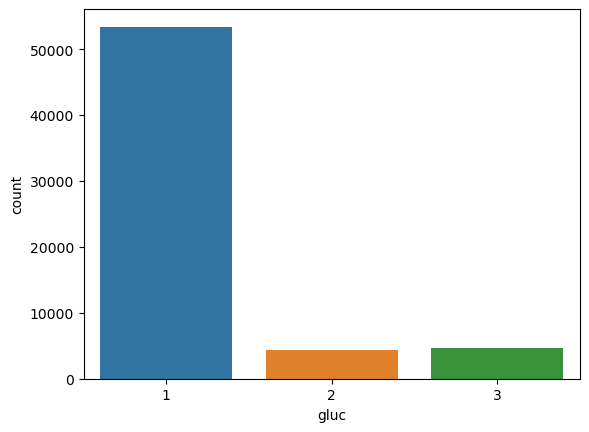

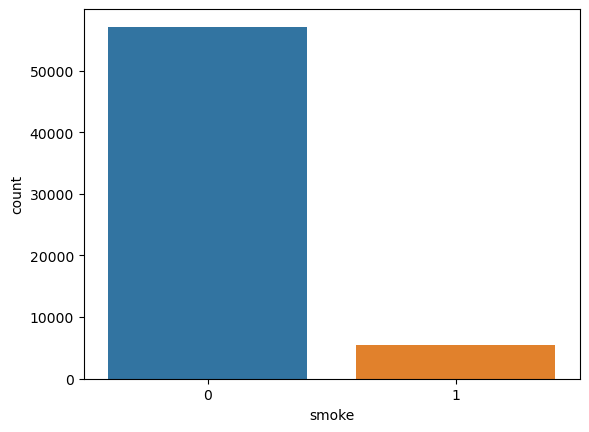

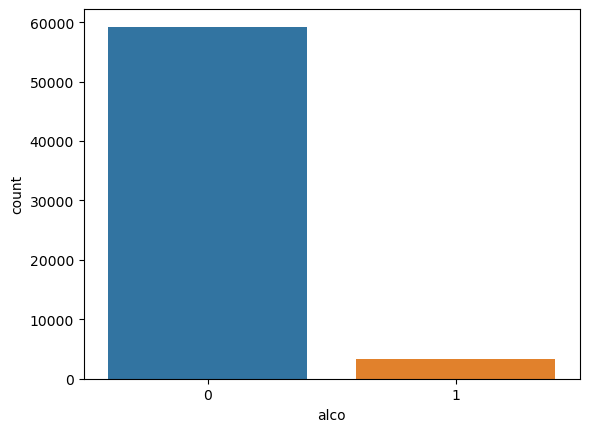

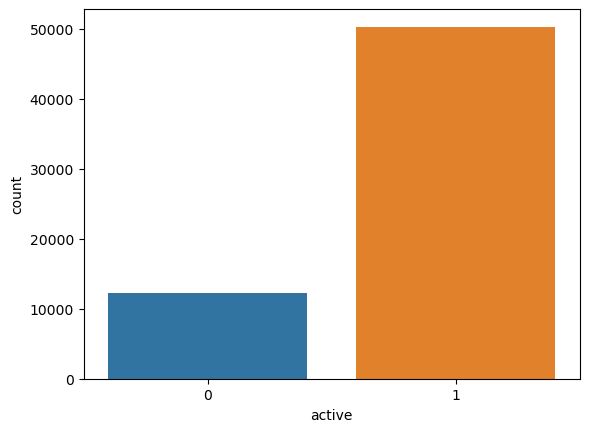

In [ ]:
palettes = ["deep", "muted", "pastel", "bright", "dark"]

for i, x in enumerate(categorical_columns):
    # sns.color_palette("husl", 8)
    sns.countplot(data=df, x=x)
    plt.xlabel(x)
    plt.show()

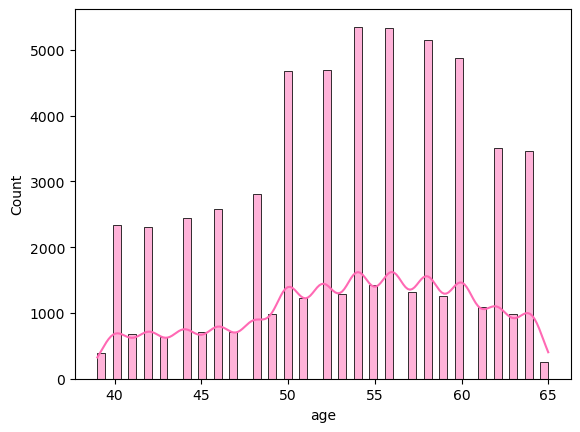

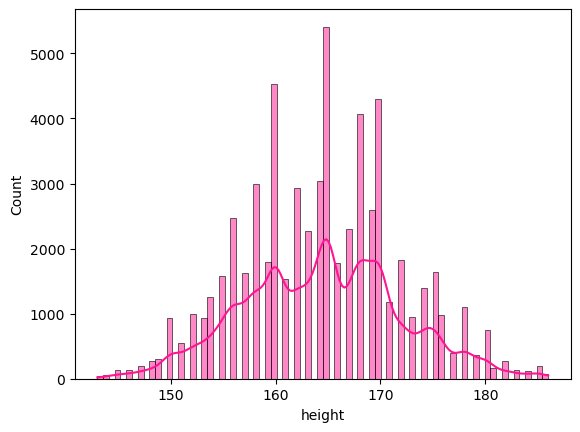

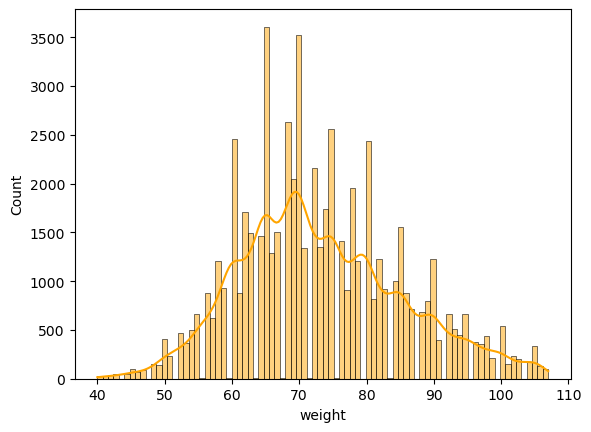

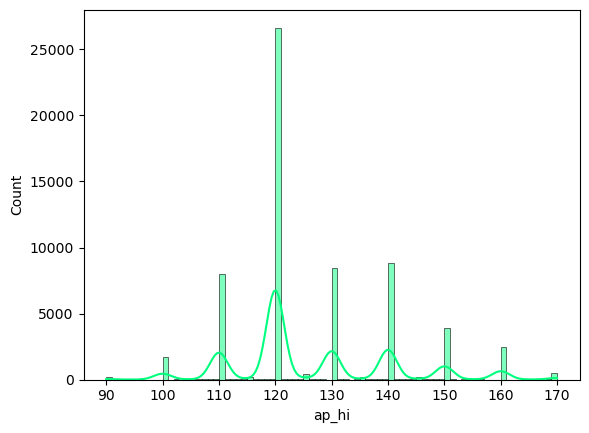

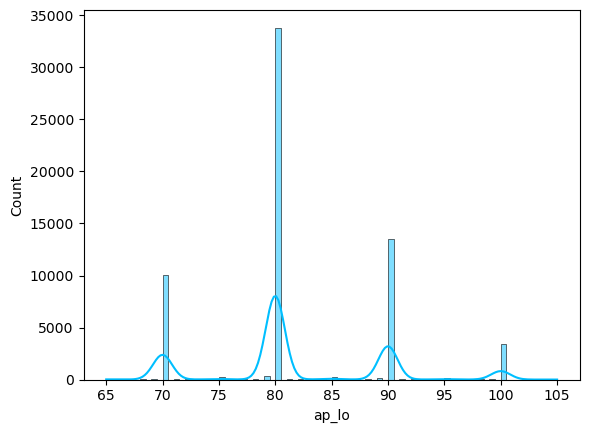

In [30]:
colors = ["#ff69b4", "#ff1493", "#ffa500", "#00ff7f", "#00bfff"]
for i, x in enumerate(continuous_columns):
    sns.histplot(data=df, x=x, kde=True, color=colors[i])
    plt.xlabel(x)
    plt.show()

## Feature Engineering 
1) weight + height --> BMI
2) clustering

## Dimension Reduction
eg: PCA

## Model Selection and Training

In [34]:
# Creating X_train which is the features without target variable, y_train which is the target variable
X_train = df.drop(labels = "cardio", axis = 1) 
y_train = df["cardio"]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.33, random_state= 42, stratify=y_train)

In [42]:
# Logistic Regression 
pipeline_mms_lr = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('logistic_regression', LogisticRegression())
])

pipeline_ss_lr = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression())
])

# Random Forest
pipeline_mms_rf = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('random_forest', RandomForestClassifier())
])

pipeline_ss_rf = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('random_forest', RandomForestClassifier())
])



In [43]:
pipelines = [pipeline_mms_lr, pipeline_ss_lr,
            pipeline_mms_rf, pipeline_ss_rf
            ]

In [44]:
pipe_dict = {}
best_score = 0
# Key for the dictionary
model_name = ['MMS + Logistic Regression', 'SS + Logistic Regression', 
              'MMS + Random Forest', 'SS + Random Forest' 
              ]

In [45]:
for pipe in pipelines:
    pipe.fit(X_train, y_train)

In [46]:
# Model Evaluation
for i, model in enumerate(pipelines):
    y_pred = model.predict(X_test)
    # key is mode_name, values are accuracy score and f1 score
    pipe_dict[model_name[i]] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')]

    # To get the best score from each model
    if model.score(X_test, y_test) > best_score:
        best_score = model.score(X_test, y_test)
        best_pipeline = model_name[i]

In [47]:
print('The best model for heart attack prediction is {} with the accuracy score of {}'.format(best_pipeline, best_score))

The best model for heart attack prediction is SS + Logistic Regression with the accuracy score of 0.7207892950644817


In [48]:
print(pipe_dict)

{'MMS + Logistic Regression': [0.7206923300688451, 0.7195444565760403], 'SS + Logistic Regression': [0.7207892950644817, 0.7196488321195327], 'MMS + Random Forest': [0.6951420537186076, 0.6951114544132297], 'SS + Random Forest': [0.6974207311160671, 0.6974102389727012]}


In [49]:
# Converting pipe into DataFrame    
model_comparison_df = pd.DataFrame.from_dict(pipe_dict).T
model_comparison_df.columns = ['Accuracy_score', 'f1_score']
model_comparison_df.sort_values(['Accuracy_score', 'f1_score'], ascending = False, inplace=True)
model_comparison_df.style.background_gradient(cmap='GnBu')

,Accuracy_score,f1_score
SS + Logistic Regression,0.720789,0.719649
MMS + Logistic Regression,0.720692,0.719544
SS + Random Forest,0.697421,0.697410
MMS + Random Forest,0.695142,0.695111


## Hyperparameter Tuning

In [50]:
pipelines_ht = [pipeline_mms_lr, pipeline_ss_lr,
            pipeline_mms_rf, pipeline_ss_rf
            ]

In [51]:
pipe_dict_ht = {}
best_score_ht = 0
# Key for the dictionary
model_name_ht = ['MMS + Logistic Regression', 'SS + Logistic Regression', 
              'MMS + Random Forest', 'SS + Random Forest', 
              'MMS + Gradient Boost', 'SS + Gradient Boost', 
              'MMS + SVC', 'SS + SVC'
              ]

In [53]:
log_param_grid = {'logistic_regression__C': np.logspace(-5, 10, 15)}

rf_param_grid = {'random_forest__n_estimators': [100, 500, 1000],
                 'random_forest__max_depth': [5, 10, 15],
                 'random_forest__min_samples_split': [2, 5, 10]}

log_param_grids = [log_param_grid]*2
rf_param_grids = [rf_param_grid]*2

param_grids = log_param_grids + rf_param_grids

In [55]:
# Below code will take around 15-20mins
best_params = {}
for i, model in enumerate(pipelines_ht):
    cv_ht = RandomizedSearchCV(model, param_distributions=param_grids[i], n_iter=10, cv=5)
    cv_ht.fit(X_train, y_train)
    best_params[model_name_ht[i]] = cv_ht.best_params_
    y_pred = cv_ht.predict(X_test)
    pipe_dict_ht[model_name_ht[i]] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')]
    if cv_ht.best_score_ > best_score_ht:
        best_pipeline_ht = model_name_ht[i]
        best_score_ht = cv_ht.best_score_

In [56]:
print(best_params)

{'MMS + Logistic Regression': {'logistic_regression__C': 26.826957952797272}, 'SS + Logistic Regression': {'logistic_regression__C': 848342898.2440726}, 'MMS + Random Forest': {'random_forest__n_estimators': 100, 'random_forest__min_samples_split': 5, 'random_forest__max_depth': 10}, 'SS + Random Forest': {'random_forest__n_estimators': 100, 'random_forest__min_samples_split': 2, 'random_forest__max_depth': 10}}


In [57]:
print('The best model for heart attack prediction is {} with the accuracy score of {}'.format(best_pipeline_ht, best_score_ht))

The best model for heart attack prediction is MMS + Random Forest with the accuracy score of 0.7311347560193303


In [58]:
print(pipe_dict_ht)

{'MMS + Logistic Regression': [0.7207408125666634, 0.719601901535413], 'SS + Logistic Regression': [0.7208377775623, 0.7196957619630968], 'MMS + Random Forest': [0.7288858722001358, 0.7278338533570469], 'SS + Random Forest': [0.7265587123048579, 0.7257422592283457]}


In [59]:
# Converting pipe into DataFrame    
model_comparison_df_ht = pd.DataFrame.from_dict(pipe_dict_ht).T
model_comparison_df_ht.columns = ['Accuracy_score', 'f1_score']
model_comparison_df_ht.sort_values(['Accuracy_score', 'f1_score'], ascending = False, inplace=True)
model_comparison_df_ht.style.background_gradient(cmap='viridis')

,Accuracy_score,f1_score
MMS + Random Forest,0.728886,0.727834
SS + Random Forest,0.726559,0.725742
SS + Logistic Regression,0.720838,0.719696
MMS + Logistic Regression,0.720741,0.719602


## Classification Report and Confusion Matrix

In [63]:
labels = ['Cardiovascular Disease Absence ', 'Cardiovascular Disease Presence ']
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, target_names = labels)

In [64]:
print(cr)

                                  precision    recall  f1-score   support

 Cardiovascular Disease Absence        0.71      0.78      0.74     10439
Cardiovascular Disease Presence        0.75      0.67      0.71     10187

                        accuracy                           0.73     20626
                       macro avg       0.73      0.73      0.73     20626
                    weighted avg       0.73      0.73      0.73     20626



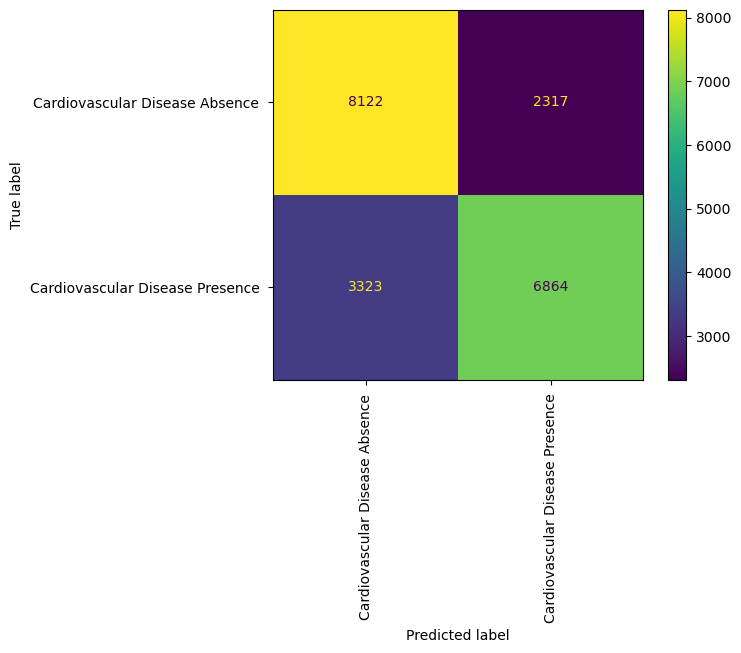

In [69]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='viridis')
plt.xticks(rotation=90)
plt.show()

## Model Saving

In [74]:
if not os.path.exists('model_for_cardio'):
    os.makedirs('model_for_cardio')

In [75]:
for i, model in enumerate(pipelines_ht):
    cv_ht = RandomizedSearchCV(model, param_distributions=param_grids[i], n_iter=10, cv=5)
    cv_ht.fit(X_train, y_train)
    MODEL_PATH = os.path.join(os.getcwd(), 'model_for_cardio', '{}.pkl'.format(model_name_ht[i]))
    with open(MODEL_PATH, 'wb') as file:
        pickle.dump(cv_ht.best_estimator_, file)

## Testing our model on new data

In [76]:
with open(MODEL_PATH, 'rb') as file:
    loaded_model = pickle.load(file)

In [79]:
test_data = pd.read_csv('datasets\cardio_train_newtest.csv', sep=";")
X_test = test_data.drop(['cardio','id'], axis=1)
y_test = test_data['cardio']

In [80]:
y_pred = loaded_model.predict(X_test)

In [81]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.8
